In [1]:
# This script is for GWR
# Take Dataset3 BUF for example

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from pysal.model import mgwr
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\ryanz\anaconda3\envs\Obesity\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\Users\ryanz\anaconda3\envs\Obesity\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [3]:
X_sociodemo_test_passed = pd.read_csv("../Data/01 Processed Dataset/Socio_BUF.csv", index_col = 'GEOID') # input
y = X_sociodemo_test_passed.pop('obesity_cr')
X_complete_test_passed = pd.read_csv("../Data/01 Processed Dataset/Complete_BUF.csv", index_col = "GEOID") # input
del X_complete_test_passed['obesity_cr']

In [4]:
# Standardization function
def standarize_data(data, stats):
    return (data - stats['mean'])/ stats['std']

In [5]:
X_sociodemo_test_passed_stats = X_sociodemo_test_passed.describe().transpose()
X_sociodemo_std_test_passed = standarize_data(X_sociodemo_test_passed, X_sociodemo_test_passed_stats)

X_complete_test_passed_stats = X_complete_test_passed.describe().transpose()
X_complete_std_test_passed = standarize_data(X_complete_test_passed, X_complete_test_passed_stats)

In [6]:
len(X_sociodemo_std_test_passed)

77

In [7]:
# Coordinates
ct_shp = gpd.read_file("../Data/05 Coordinates info for GWR/BUF_CDC data_Tract_Ob_pro.shp") # input
ct_shp['GEOID'] = ct_shp['GEOID'].astype('int64')

study_ct = X_sociodemo_std_test_passed.merge(ct_shp, on='GEOID', how='left')
study_ct['Lonpro'] = pd.to_numeric(study_ct['Lonpro']) 
study_ct['Latpro'] = pd.to_numeric(study_ct['Latpro']) 

lng_lat_coords = np.column_stack([study_ct['Lonpro'], study_ct['Latpro']])

<AxesSubplot:>

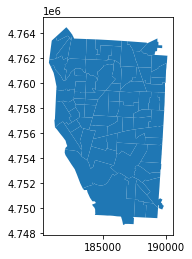

In [8]:
ct_shp.plot()

In [9]:
# Bandwidth
# https://mgwr.readthedocs.io/en/latest/api.html
socio_selector = mgwr.sel_bw.Sel_BW(lng_lat_coords, 
                                    np.asarray(y).reshape(-1,1), 
                                    np.asarray(X_sociodemo_std_test_passed), 
                                    spherical=False)

socio_bw = socio_selector.search(criterion='AICc') # golden section search; AIC; number of nearest neighbor
print(socio_bw)

ValueError: kth(=86) out of bounds (77)

In [11]:
# Error, so use 77.
# sociodemographic predictors
#fit GWR model
socio_gwr_model = mgwr.gwr.GWR(lng_lat_coords, 
                               np.asarray(y).reshape(-1,1), 
                               np.asarray(X_sociodemo_std_test_passed), 
                               77)

socio_gwr_results = socio_gwr_model.fit()
socio_gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                  77
Number of covariates:                                                    22

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             91.117
Log-likelihood:                                                    -115.739
AIC:                                                                275.479
AICc:                                                               298.309
BIC:                                                               -147.792
R2:                                                                   0.976
Adj. R2:                                                              0.966

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [12]:
#obtain prediction
y_gwr_socio_predict3 = socio_gwr_results.predy

#calculate RMSE
gwr_socio_rmse_3 = mean_squared_error(y , y_gwr_socio_predict3, squared=False)
print("RMSE of GWR with sociodemographic predictors: ", gwr_socio_rmse_3)

RMSE of GWR with sociodemographic predictors:  0.9335878627942251


In [13]:
complete_selector = mgwr.sel_bw.Sel_BW(lng_lat_coords, 
                                       np.asarray(y).reshape(-1,1),
                                       np.asarray(X_complete_std_test_passed),
                                       spherical=False)

complete_bw = complete_selector.search(criterion='AICc')
print(complete_bw)

ValueError: kth(=94) out of bounds (77)

In [14]:
# Error, so use 77.
# add diet and physical activity measurements
#fit GWR model
complete_gwr_model = mgwr.gwr.GWR(lng_lat_coords, 
                               np.asarray(y).reshape(-1,1), 
                               np.asarray(X_complete_std_test_passed),         
                               77) #using bw from bw search on demographic predictors

complete_gwr_results = complete_gwr_model.fit()
complete_gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                  77
Number of covariates:                                                    25

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             89.581
Log-likelihood:                                                    -115.085
AIC:                                                                280.170
AICc:                                                               310.250
BIC:                                                               -136.297
R2:                                                                   0.976
Adj. R2:                                                              0.965

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [15]:
#obtain prediction
y_gwr_complete_predict2 = complete_gwr_results.predy
#calculate RMSE
gwr_complete_rmse_2 = mean_squared_error(y , y_gwr_complete_predict2, squared=False)
print("RMSE of GWR adding alcohol visit predictors: ", gwr_complete_rmse_2)

RMSE of GWR adding alcohol visit predictors:  0.9141391004636409


26.1
49.1
25.741342124943912
49.4693659272582


<Figure size 720x576 with 0 Axes>

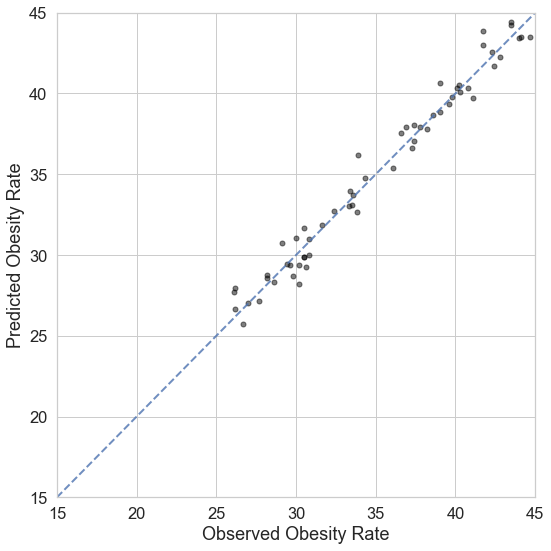

In [16]:
# GWR scatter-curve plot
import matplotlib

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 28}

matplotlib.rc('font', **font)

plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid",font_scale = 1.5)

def prediction_scatter(true_label, prediction, lims, title):
    plt.figure(figsize=(8,8))
    scatter = plt.plot(true_label, prediction, "o", markersize=5, alpha=0.5, color="black")
    line = plt.plot(lims, lims, "b--",alpha=0.8, linewidth=2)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel('Observed Obesity Rate')
    plt.ylabel('Predicted Obesity Rate')
    plt.title(title)
    
print(np.min(y))
print(np.max(y))
print(np.min(y_gwr_complete_predict2))
print(np.max(y_gwr_complete_predict2))

#scatter plot
lims = [15, 45]
prediction_scatter(y, y_gwr_complete_predict2, lims, "")
plt.tight_layout()
# plt.savefig("../GWR_pred_origin_BUF.png",dpi=300)

In [17]:
# Coefficient maps
feature_list = X_complete_std_test_passed.columns.tolist()
col_nam = ['const']+feature_list # const is like constant

#obtain coefficients from the GWR
df_coef = pd.DataFrame(
    data=complete_gwr_results.params,
    columns=col_nam,
    index=X_complete_std_test_passed.index
) 

# merge the geometry of CBG
ct_geometry = study_ct[['GEOID','geometry']]
df_coef = df_coef.merge(ct_geometry, on='GEOID',how='left')
gdf_coef = gpd.GeoDataFrame(df_coef, geometry='geometry')
gdf_place_coef = gdf_coef[['GEOID','fafood','fitness','park','geometry']]

gdf_place_coef.to_file("../02 Dataset/12 Locol coefficient for GWR/GWR_place_coef_BUF.shp")

In [20]:
from pathlib import Path
import pandas
import geopandas

folder = Path("../02 Dataset/12 Locol coefficient for GWR")
shapefiles = folder.glob("*.shp")
gdf = pandas.concat([
    geopandas.read_file(shp)
    for shp in shapefiles
]).pipe(geopandas.GeoDataFrame)
gdf.to_file(folder / 'Locol coefficient.shp')

In [21]:
gdf

,GEOID,fafood,fitness,park,geometry
0,36029000500,-0.156913,-0.014192,0.140248,"POLYGON ((181917.184 4754674.446, 182207.061 4..."
1,36029000700,-0.104204,-0.013209,0.091044,"POLYGON ((188226.327 4750239.434, 188231.790 4..."
2,36029000900,-0.108498,-0.018824,0.087753,"POLYGON ((187600.152 4751953.840, 187608.648 4..."
3,36029001000,-0.105027,-0.019145,0.079674,"POLYGON ((188157.863 4752033.794, 188362.071 4..."
4,36029001100,-0.109683,-0.024515,0.078051,"POLYGON ((187466.665 4752786.825, 187489.104 4..."
...,...,...,...,...,...
1990,36081108500,0.176875,-0.030299,0.123658,"POLYGON ((601634.861 4514259.486, 601803.565 4..."
1991,36081109300,0.135490,-0.110680,0.089095,"POLYGON ((602563.792 4514617.602, 602578.820 4..."
1992,36081141700,0.322454,-0.401736,-0.051355,"POLYGON ((601532.531 4511638.232, 601603.560 4..."
1993,36081006202,-0.487461,-0.352411,0.238111,"POLYGON ((596102.112 4501444.923, 596241.586 4..."
